# GUC Clustering Project 

**Objective:** 
The objective of this project teach students how to apply clustering to real data sets

The projects aims to teach student: 
* Which clustering approach to use
* Compare between Kmeans, Hierarchal, DBScan, and Gaussian Mixtures  
* How to tune the parameters of each data approach
* What is the effect of different distance functions (optional) 
* How to evaluate clustering approachs 
* How to display the output
* What is the effect of normalizing the data 

Students in this project will use ready-made functions from Sklearn, plotnine, numpy and pandas 
 



Running this project require the following imports 

In [3]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
# StandardScaler is a function to normalize the data 
# You may also check MinMaxScaler and MaxAbsScaler 
#from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

%matplotlib inline

In [4]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'  #List colors
    alpha = 0.5  #color obaque
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

## Multi Blob Data Set 
* The Data Set generated below has 6 cluster with varying number of users and varing densities
* Cluster the data set below using 



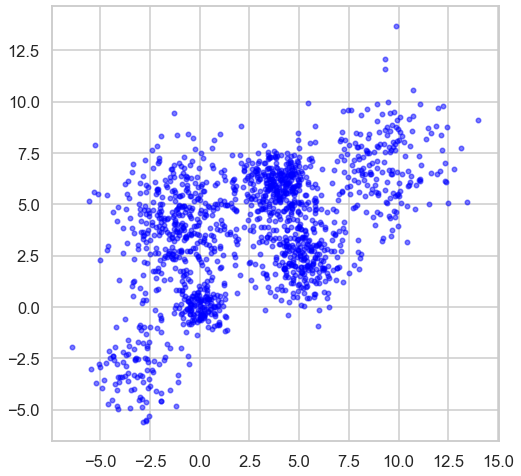

In [5]:
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
sns.set_context("talk")

n_bins = 6  
centers = [(-3, -3), (0, 0), (5,2.5),(-1, 4), (4, 6), (9,7)]
Multi_blob_Data, y = make_blobs(n_samples=[100,150, 300, 400,300, 200], n_features=2, cluster_std=[1.3,0.6, 1.2, 1.7,0.9,1.7],
                  centers=centers, shuffle=False, random_state=42)
display_cluster(Multi_blob_Data)

### Kmeans 
* Use Kmeans with different values of K to cluster the above data 
* Display the outcome of each value of K 
* Plot distortion function versus K and choose the approriate value of k 
* Plot the silhouette_score versus K and use it to choose the best K 
* Store the silhouette_score for the best K for later comparison with other clustering techniques. 

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = [2, 3, 4, 5, 6]
results = {}
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Multi_blob_Data)
    results[k] = {'model': kmeans, 'silhouette': silhouette_score(Multi_blob_Data, kmeans.labels_)}
print(results)

{2: {'model': KMeans(n_clusters=2), 'silhouette': 0.4751544541991239}, 3: {'model': KMeans(n_clusters=3), 'silhouette': 0.43631793714185435}, 4: {'model': KMeans(n_clusters=4), 'silhouette': 0.4628725400351352}, 5: {'model': KMeans(n_clusters=5), 'silhouette': 0.48100602217073085}, 6: {'model': KMeans(n_clusters=6), 'silhouette': 0.4863587776714135}}


### Hierarchal Clustering
* Use AgglomerativeClustering function to  to cluster the above data 
* In the  AgglomerativeClustering change the following parameters 
    * Affinity (use euclidean, manhattan and cosine)
    * Linkage( use average and single )
    * Distance_threshold (try different)
* For each of these trials plot the Dendograph , calculate the silhouette_score and display the resulting clusters  
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observation 

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score

affinities = ['euclidean', 'manhattan', 'cosine']
linkages = ['average', 'single']
distance_thresholds = [None, 2, 4, 6]

results = {}
for affinity in affinities:
    for linkage in linkages:
        for distance_threshold in distance_thresholds:
            if distance_threshold is None:
                model = AgglomerativeClustering(n_clusters=3, affinity=affinity, linkage=linkage)
            else:
                model = AgglomerativeClustering(n_clusters=None,affinity=affinity, linkage=linkage,
                                                 distance_threshold=distance_threshold)
            model.fit(Multi_blob_Data)
            if len(set(model.labels_)) == 1:
                results[(affinity, linkage, distance_threshold)] = {'model': model,
                                                                 'silhouette': None}
            else:
                results[(affinity, linkage, distance_threshold)] = {'model': model,
                                                                 'silhouette': silhouette_score(Multi_blob_Data, model.labels_)}
print(results)

{('euclidean', 'average', None): {'model': AgglomerativeClustering(linkage='average', n_clusters=3), 'silhouette': 0.4307906732655957}, ('euclidean', 'average', 2): {'model': AgglomerativeClustering(distance_threshold=2, linkage='average',
                        n_clusters=None), 'silhouette': 0.31557101720950825}, ('euclidean', 'average', 4): {'model': AgglomerativeClustering(distance_threshold=4, linkage='average',
                        n_clusters=None), 'silhouette': 0.37378418096239385}, ('euclidean', 'average', 6): {'model': AgglomerativeClustering(distance_threshold=6, linkage='average',
                        n_clusters=None), 'silhouette': 0.4307906732655957}, ('euclidean', 'single', None): {'model': AgglomerativeClustering(linkage='single', n_clusters=3), 'silhouette': 0.23622772250901033}, ('euclidean', 'single', 2): {'model': AgglomerativeClustering(distance_threshold=2, linkage='single', n_clusters=None), 'silhouette': 0.3218066204847175}, ('euclidean', 'single', 4): {'

### DBScan
* Use DBScan function to  to cluster the above data 
* In the  DBscan change the following parameters 
    * EPS (from 0.1 to 3)
    * Min_samples (from 5 to 25)
* Plot the silhouette_score versus the variation in the EPS and the min_samples
* Plot the resulting Clusters in this case 
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observations and comments 

In [12]:
from sklearn.cluster import DBSCAN

EPS = np.arange(0.1, 3.1, 0.2)
Min_samples = np.arange(5,25,5)

results={}
for e in EPS:
    for s in Min_samples:
        dbscan = DBSCAN(eps=e, min_samples=s)
        dbscan.fit(Multi_blob_Data)
        if len(set(dbscan.labels_)) == 1:
            results[(e,s)]={"model":dbscan,"silhouette_score":None}
        else:
            results[(e,s)]={"model":dbscan,"silhouette_score":silhouette_score(Multi_blob_Data,dbscan.labels_)}
print(results)

{(0.1, 5): {'model': DBSCAN(eps=0.1), 'silhouette_score': -0.542334843260597}, (0.1, 10): {'model': DBSCAN(eps=0.1, min_samples=10), 'silhouette_score': None}, (0.1, 15): {'model': DBSCAN(eps=0.1, min_samples=15), 'silhouette_score': None}, (0.1, 20): {'model': DBSCAN(eps=0.1, min_samples=20), 'silhouette_score': None}, (0.30000000000000004, 5): {'model': DBSCAN(eps=0.30000000000000004), 'silhouette_score': -0.13789448202067037}, (0.30000000000000004, 10): {'model': DBSCAN(eps=0.30000000000000004, min_samples=10), 'silhouette_score': -0.3105062437345893}, (0.30000000000000004, 15): {'model': DBSCAN(eps=0.30000000000000004, min_samples=15), 'silhouette_score': -0.2058371920105014}, (0.30000000000000004, 20): {'model': DBSCAN(eps=0.30000000000000004, min_samples=20), 'silhouette_score': -0.3770487961292272}, (0.5000000000000001, 5): {'model': DBSCAN(eps=0.5000000000000001), 'silhouette_score': -0.07318209741938365}, (0.5000000000000001, 10): {'model': DBSCAN(eps=0.5000000000000001, min_s

### Gaussian Mixture
* Use GaussianMixture function to cluster the above data 
* In GMM change the covariance_type and check the difference in the resulting proabability fit 
* Use a 2D contour plot to plot the resulting distribution (the components of the GMM) as well as the total Gaussian mixture 

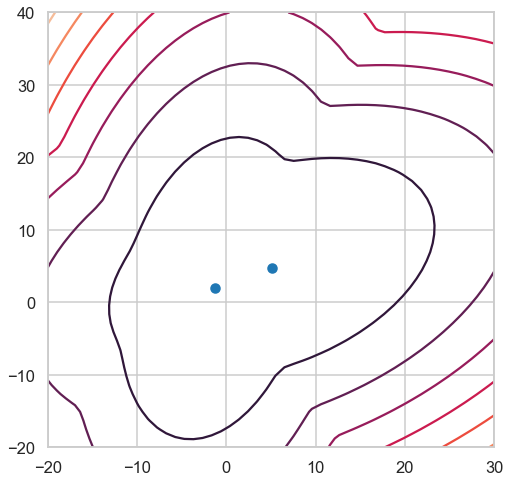

In [22]:
from sklearn import mixture

covariance_type = ["full"]
results = {}
for cov in covariance_type:
    gmm =  mixture.GaussianMixture(n_components = 2,covariance_type=cov)
    gmm.fit(Multi_blob_Data)
    results[cov] = {"model":gmm}
    x = np.linspace(-20.0, 30.0)
    y = np.linspace(-20.0, 40.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = - gmm.score_samples(XX)
    Z = Z.reshape(X.shape)
    contours = plt.contour(X, Y, Z)
    cn = np.transpose(gmm.means_)
    centers = plt.scatter(cn[0],cn[1])
    plt.show()



## iris data set 
The iris data set is test data set that is part of the Sklearn module 
which contains 150 records each with 4 features. All the features are represented by real numbers 

The data represents three classes 


In [ ]:
from sklearn.datasets import load_iris
iris_data = load_iris()
list(iris_data.values())# type: ignore
# ['setosa', 'versicolor', 'virginica']


* Repeat all the above clustering approaches and steps on the above data 
* Normalize the data then repeat all the above steps 
* Compare between the different clustering approaches 

## Customer dataset
Repeat all the above on the customer data set 